<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/04/cropped-Logo_Quantreo_transparent.png" align="left" hspace="10px" vspace="0px"></p>

# BackTesting
Backtesting is an essential part of trading. Indeed, it is important to understand the behavior of your strategy in the past to be able to consider those of future.
### Content

* Sortino Beta Alpha
* Drawdown 
* Create function BackTest to evaluate the strategy in the later sections

### Environnement

In [ ]:
!pip install yfinance
!pip install ta

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import ta
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

### Function

In [ ]:
def RSI(val,neutral, window):
  """ 
        ------------------------------------------------------------------------------
        | Output: The function gives the returns of RSI strategy                     |
        ------------------------------------------------------------------------------
        | Inputs: -val (type dataframe pandas): Entry values of the stock            |
        |         -neutral (float): Value of neutrality, i.e. no action zone         |
        |         -window (float): rolling period for RSI                            |
        ------------------------------------------------------------------------------
  """

  # Print Error if there is no column Adj Close in the dataframe
  if "Adj Close" not in val.columns:
    ValueError("We need have a columns name Adj Close because all computation are about this column")
  
  val["rsi"] = ta.momentum.RSIIndicator(f["Adj Close"], window=window).rsi()


  
  """ Long buy Signal """
  # We put threshold
  overbuy = 70
  neutral_buy = 50 + neutral

  # Put nan values for the signal long columns
  val["signal_long"] = np.nan
  val["yersteday_rsi"] = f["rsi"].shift(1)
  # We need define the Open Long signal (RSI yersteday<55 and RSI today>55)
  val.loc[(val["rsi"]>neutral_buy) & (val["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

  # We need define the Close Long signal (RSI yersteday>55 and RSI today<55) False signal
  val.loc[(val["rsi"]<neutral_buy)&(val["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

  # We need define the Close Long signal (RSI yersteday>70 and RSI today<70) Over buy signal
  val.loc[(val["rsi"]<overbuy)&(val["yersteday_rsi"]>overbuy), "signal_long"] = 0



  """Short sell signal """
  # We put threshold
  oversell = 30
  neutral_buy = 50 - neutral

  # Put nan values for the signal short columns
  val["signal_short"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # We need define the Open Short signal (RSI yersteday>45 and RSI today<45)
  val.loc[(val["rsi"]<neutral_buy) & (val["yersteday_rsi"]>neutral_buy), "signal_short"] = -1

  # We need define the Close Short signal (RSI yersteday<45 and RSI today>45) False signal
  val.loc[(val["rsi"]>neutral_buy)&(val["yersteday_rsi"]<neutral_buy), "signal_short"] = 0

  # We need define the Close Short signal (RSI yersteday<30 and RSI today>30) Over sell signal
  val.loc[(val["rsi"]>oversell)&(val["yersteday_rsi"]<oversell), "signal_short"] = 0


  """ Compute the returns """
  # Compute the percentage of variation of the asset
  val["pct"] = val["Adj Close"].pct_change(1)

  # Compute the positions
  val["Position"] = (val["signal_short"].fillna(method="ffill")+ val["signal_long"].fillna(method="ffill"))

  # Compute the return of the strategy
  val["return"] = val["pct"]*(val["Position"].shift(1))

  return val["return"]

# Section 1: Sortino Beta Alpha

###### Sortino
The sortino ratio is a statistic similar to the sharpe ratio with the same interpretation. However, the calculation is slightly different. Indeed, in the sortino ratio we only take into account the volatility of the negative gains because that is what we fear and not the bullish gains that make us earn money. <br>
<p align="center">
$Sortino = \frac{\mu }{\sigma_{down}}$
<p> <br>

*   SortinoRatio < 0 : Not profitable investissement because you gains is negative.
*   SortinoRatio < 1 : Profitable investissement but the risk of the investissement is higher than the returns.
*   SortinoRatio > 1: Very good investissement because the risk is lower than the returns.


In [ ]:
# Prepare the datas
f = yf.download("GOOG", end="2021-01-01")
return_serie = RSI(f,5, 14)

# Compute the sortino
sortino = np.sqrt(252) * return_serie.mean()/return_serie[return_serie<0].std()
print(f"Sortino: {np.round(sortino,3)}")

[*********************100%***********************]  1 of 1 completed
Sortino: 0.309


###### Beta
The beta is a statistic that indicates the relationship between the variations of our portfolio and those of the market which is represented by an index (for example SP500). <br>

<p align="center">
$Beta = \frac{Cov(r_{M},r_{PF}) }{Var(r_{M})}$
<p> <br>



*   abs(Beta) < 1: It is good because it means that your portfolio have a less variation than the index. (If beta=0.9 this means that if the index varies of 1 the portfolio varies by 0.9)
*   abs(Beta) > 1: It is not a good thing because it means that your portfolio have a higher variation than the index. (If beta=1.1 this means that if the index varies of 1 the portfolio varies by 1.1)

**abs(-x) = x = abs(x) (abs gives only the value of the variable not the sign)*


In [ ]:
# We need compute the covariance between the marlet and the portfolio 
sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
sp500.name = "SP500"

# We conacate them to do the covariances
val = pd.concat((return_serie,sp500), axis=1).dropna()

# We compute beta 
beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)
print(f" Beta: {np.round(beta,3)}")

[*********************100%***********************]  1 of 1 completed
 Beta: -0.166


###### **Alpha**
Alpha is a statistic that indicates whether the portfolio outperforms the market in terms of risk return. <br>

<p align="center">
$Alpha = r_{PF} - \beta*(r_{PF} - r_{f}) - r_{f}$
<p> <br>


*   alpha > 0: The portfolio outperforms the market in terms of risk return
*   alpha < 0: The portfolio underperforms the market in terms of risk return


In [ ]:
# We compute alpha
alpha = 252*return_serie.mean() - 252*beta*return_serie.mean()
print(f"Alpha: {np.round(alpha,5)}")

Alpha: 0.0792


# Section 2: Drawdown

The drawdown is a measure of the risk of the strategy. An interesting statistic to know the performance of the algorithm is the maximum drawdown. Indeed, it represents the maximum loss of a strategy over a period of time which allows you to understand if the strategy is risky and thus choose it according to your level of risk aversion.

In [ ]:
def drawdown_function(serie):

  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum()+1

  # We compute max of the cumsum on the period (accumulate max)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown  = cum/running_max - 1 
  return drawdown

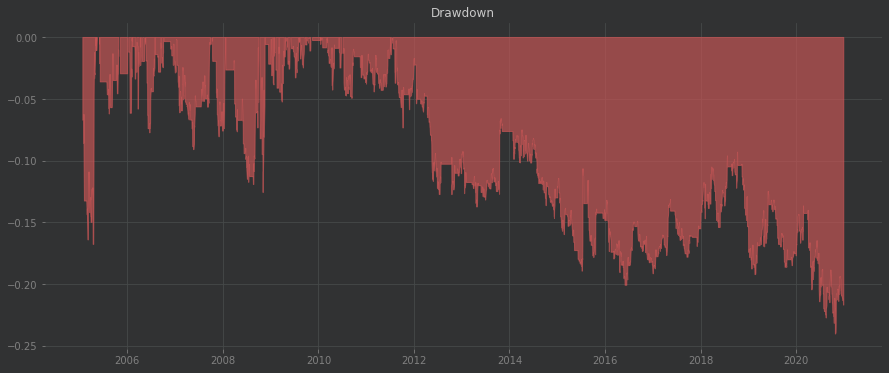

In [ ]:
# We compute drawdown
drawdown = drawdown_function(return_serie)

# Adapt figure size
plt.figure(figsize=(15,6))

# Plot the drawdown
plt.fill_between(drawdown.index, drawdown, 0,
                drawdown<0, color="#CE5757", alpha=0.65)

# Put a title
plt.title(f"Drawdown")
plt.show()


In [ ]:
# Computation Max drawdown
max_drawdown =  -np.min(drawdown)*100
print(f"Max drawdown: {np.round(max_drawdown,1)} %")

Max drawdown: 24.0 %


# Section 3: Create function BackTest to evaluate the strategy in the later sections

[*********************100%***********************]  1 of 1 completed


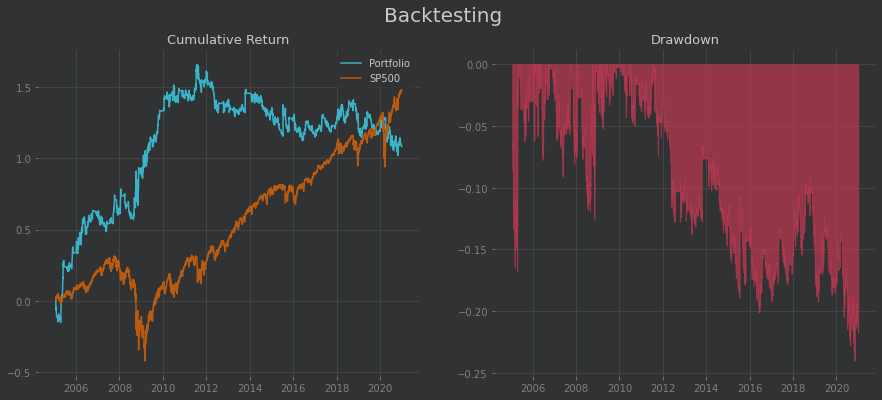

Sortino: 0.309
Beta: -0.166
Alpha: 0.079
MaxDrawdown: 24.041 %


In [ ]:
def BackTest(serie):

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  # Concat the returns and the sp500
  val = pd.concat((serie,sp500), axis=1).dropna()
  
  # Compute the drawdown
  drawdown = drawdown_function(serie)
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(15,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum(), color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum(), color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  # Plot the graph
  plt.show()




  # Compute the sortino
  sortino = np.sqrt(252) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = 252*serie.mean() - 252*beta*serie.mean()

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha,3)}")
  print(f"MaxDrawdown: {np.round(max_drawdown*100,3)} %")
BackTest(return_serie)